<a href="https://colab.research.google.com/github/Wyndegarde/MS984/blob/main/Churn_Final_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages and Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from imblearn.over_sampling import SMOTENC
from collections import Counter

In [ ]:
companyA = pd.read_csv("drive/MyDrive/CompanyA.csv")
companyB = pd.read_csv("drive/MyDrive/CompanyB.csv")

# Data Cleaning

In [ ]:
companyA.loc[companyA['MonthlyCharges'] == 61.9]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.9,,No
4080,6852,2408-PSJVE,Male,0,Yes,Yes,44,Yes,No,DSL,No,Yes,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,61.9,2924.05,No


In [ ]:
companyA = companyA.replace(r'^\s*$', np.NaN, regex=True)

In [ ]:
companyA[companyA["TotalCharges"].isna()] # No senior citizens, all 0 year contracts. No Churns. No issue dropping rows.

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
356,6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,NaN,No
634,1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
2771,3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
3086,5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
3255,3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
4326,936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
5375,753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
5382,4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5695,488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
5951,1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No


In [ ]:
companyA['TotalCharges'].isna().sum()

10

In [ ]:
companyA = companyA.dropna()
companyA["TotalCharges"] = companyA.TotalCharges.astype(float)
companyA.loc[companyA['MonthlyCharges'] == 61.9]

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4080,6852,2408-PSJVE,Male,0,Yes,Yes,44,Yes,No,DSL,No,Yes,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,61.9,2924.05,No


# Exploratory Analysis

## Inital look at Churn percentage

In [ ]:
companyA["Churn"].value_counts()

No     4389
Yes    1587
Name: Churn, dtype: int64

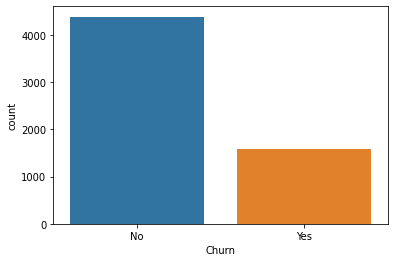

In [ ]:
sns.countplot(companyA["Churn"])

In [ ]:
num_retained_A = companyA[companyA.Churn == "No"].shape[0]
num_churned_A = companyA[companyA.Churn == "Yes"].shape[0]

print( round(num_retained_A/ (num_retained_A + num_churned_A) * 100,2), "% of people who stayed with company A")

73.44 % of people who stayed with company A


## Feature Engineering

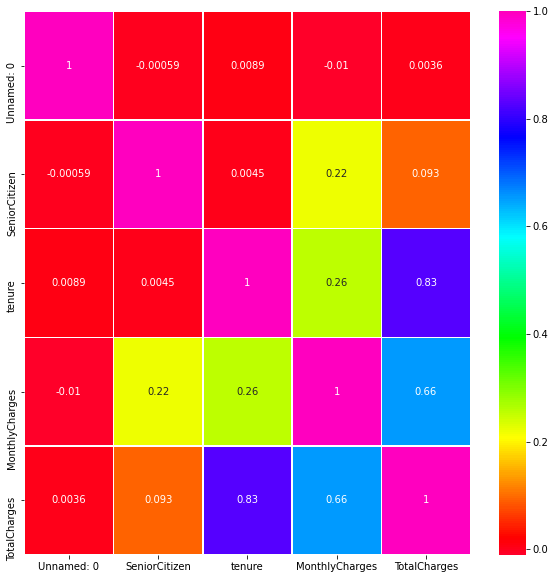

In [ ]:
corr = companyA.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot = True, linewidth = 0.5,cmap="gist_rainbow")

Drop TotalCharges because of multicollinearity

In [ ]:
companyA_extra = companyA.copy()

In [ ]:
companyA_extra["Extra Packages"] = 0
subset = ['MultipleLines','OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies'] 
companyA_extra_subset = companyA_extra[subset]

In [ ]:
companyA_extra_subset.head()

,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service
1,No,No,Yes,Yes,No,Yes,No
2,Yes,No,No,No,No,No,No
3,No,No,No,No,No,No,Yes
4,No,Yes,No,Yes,No,No,No


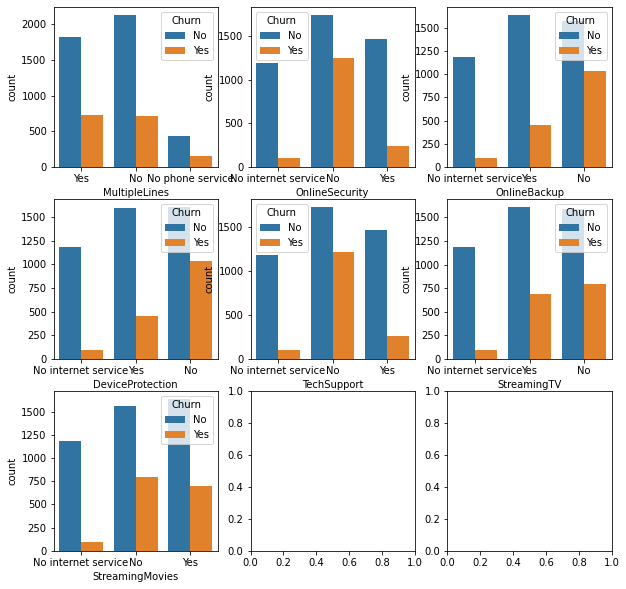

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols=3, figsize = (10,10))
sns.countplot(x = subset[0], hue = "Churn", data = companyA_extra, ax = axs[0,0])
sns.countplot(x = subset[1], hue = "Churn", data = companyA_extra, ax = axs[0,1])
sns.countplot(x = subset[2], hue = "Churn", data = companyA_extra, ax = axs[0,2])
sns.countplot(x = subset[3], hue = "Churn", data = companyA_extra, ax = axs[1,0])
sns.countplot(x = subset[4], hue = "Churn", data = companyA_extra, ax = axs[1,1])
sns.countplot(x = subset[5], hue = "Churn", data = companyA_extra, ax = axs[1,2])
sns.countplot(x = subset[6], hue = "Churn", data = companyA_extra, ax = axs[2,0])

Can see here that Device protection, Online security, Online Backup and Tech Support have an impact on Churn, so only consider these for "Extra Packages"

In [ ]:
subset = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport']
companyA_extra_subset = companyA_extra[subset]

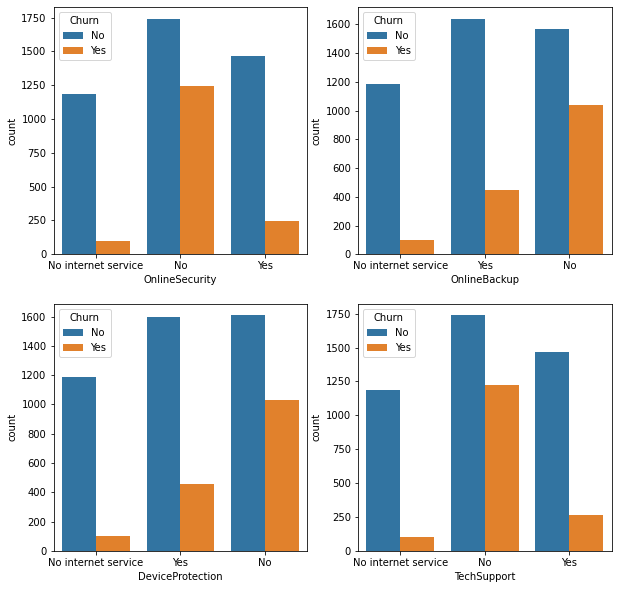

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize = (10,10))
sns.countplot(x = subset[0], hue = "Churn", data = companyA_extra, ax = axs[0,0])
sns.countplot(x = subset[1], hue = "Churn", data = companyA_extra, ax = axs[0,1])
sns.countplot(x = subset[2], hue = "Churn", data = companyA_extra, ax = axs[1,0])
sns.countplot(x = subset[3], hue = "Churn", data = companyA_extra, ax = axs[1,1])

In [ ]:
for i in range(0,len(subset)): 
  for j in range(0,companyA_extra.shape[0]):
    if companyA_extra_subset.iloc[j,i] == "Yes":   # This loop goes through each of the selected features, if a customer has that package, their "Extra Packages" increases by 1
      companyA_extra.iloc[j,22] += 1
    else:
      continue

In [ ]:
companyA_extra.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Extra Packages
0,1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No,0
1,4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No,2
2,6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes,0
3,6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No,0
4,432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No,2


## More detailed look at Churn distributions

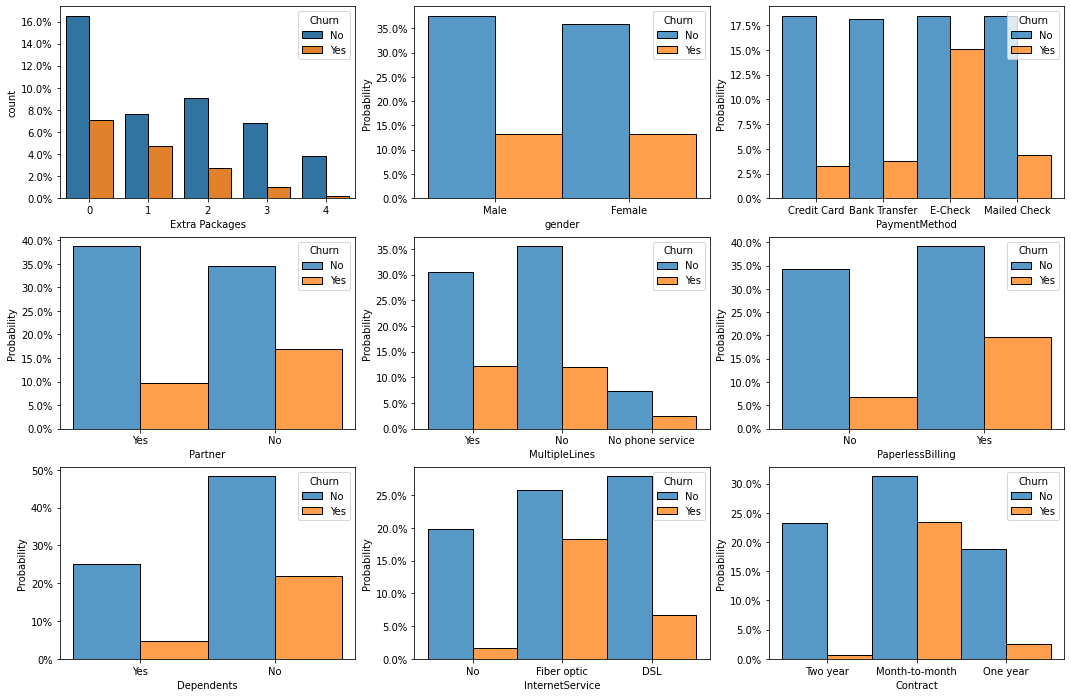

In [ ]:
fig, axs = plt.subplots(nrows = 3, ncols=3, figsize = (18,12))
sns.countplot(x = "Extra Packages", hue = "Churn", data = companyA_extra, ax = axs[0,0])
sns.histplot(x = "gender", hue = "Churn", data = companyA_extra, stat = "probability",multiple="dodge", ax = axs[0,1])
sns.histplot(x = "PaymentMethod", hue = "Churn", data = companyA_extra, stat = "probability", multiple="dodge",ax = axs[0,2])
axs[0,2].set_xticklabels(["Credit Card","Bank Transfer","E-Check","Mailed Check"])
sns.histplot(x = "Partner", hue = "Churn", data = companyA_extra, stat = "probability", multiple="dodge",ax = axs[1,0])
sns.histplot(x = "MultipleLines", hue = "Churn", data = companyA_extra, stat = "probability", multiple="dodge",ax = axs[1,1])
sns.histplot(x = "PaperlessBilling", hue = "Churn", data = companyA_extra, stat = "probability",multiple="dodge", ax = axs[1,2])
sns.histplot(x = "Dependents", hue = "Churn", data = companyA_extra, stat = "probability", multiple="dodge",ax = axs[2,0])
sns.histplot(x = "InternetService", hue = "Churn", data = companyA_extra, stat = "probability", multiple="dodge",ax = axs[2,1])
sns.histplot(x = "Contract", hue = "Churn", data = companyA_extra, stat = "probability",multiple="dodge", ax = axs[2,2])
for i in range(0,3):
  for j in range(0,3):
    if i== 0 and j == 0:
      axs[i,j].yaxis.set_major_formatter(mtick.PercentFormatter(10000))
    else:
      axs[i,j].yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.rcParams["patch.force_edgecolor"] = True

In [ ]:
companyA_extra["Extra Packages"] = companyA_extra["Extra Packages"].astype('object')

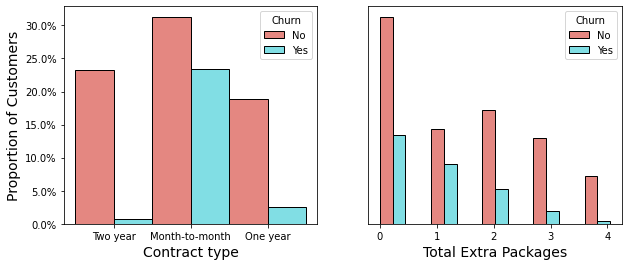

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols=2, figsize = (10,4))
sns.histplot(x = "Contract", hue = "Churn", data = companyA_extra, stat = "probability",multiple="dodge", palette=sns.color_palette("hls",2), ax = axs[0])
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[0].set_ylabel("Proportion of Customers",size = 14)
axs[0].set_xlabel("Contract type",size = 14)
sns.histplot(x = "Extra Packages", hue = "Churn", data = companyA_extra, stat = "probability",multiple="dodge", palette=sns.color_palette("hls",2), binwidth = 0.45, ax = axs[1])
axs[1].set_yticklabels(labels = "")
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[1].set_xlabel("Total Extra Packages",size = 14)
plt.rcParams["patch.force_edgecolor"] = True

In [ ]:
Contract_Proportions = companyA_extra.groupby(["Churn","Contract"]).size()
print(round(Contract_Proportions["Yes","Month-to-month"]/sum(Contract_Proportions) * 100, 2), "% of people with a month-to-month contract churned")

23.39 % of people with a month-to-month contract churned


In [ ]:
Contract_Proportions1 = companyA_extra.groupby(["Churn","Contract"]).size()
print(round(Contract_Proportions1["Yes","Two year"]/sum(Contract_Proportions1) * 100, 2), "% of people with a 2 year contract churned")

0.69 % of people with a 2 year contract churned


In [ ]:
Extra_Packages_Proportions = companyA_extra.groupby(["Churn","Extra Packages"]).size()
print(round(Extra_Packages_Proportions["Yes",0]/sum(Extra_Packages_Proportions) * 100, 2), "% of people with no extra packages churned")

11.93 % of people with no extra packages churned


In [ ]:
Extra_Packages_Proportions1 = companyA_extra.groupby(["Churn","Extra Packages"]).size()
print(round(Extra_Packages_Proportions1["Yes",4]/sum(Extra_Packages_Proportions1) * 100, 2), "% of people with four extra packages churned")

0.37 % of people with four extra packages churned


Text(0, 0.5, 'Probability')

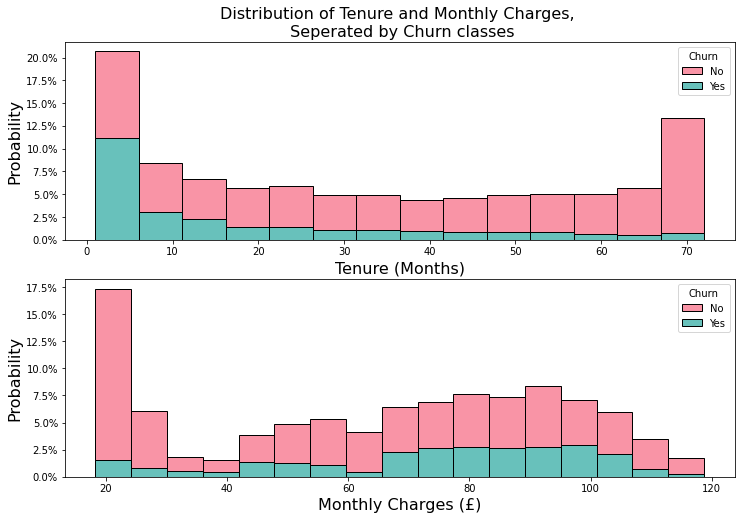

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols=1, figsize = (12,8))
sns.histplot(x = 'tenure', hue = 'Churn',data = companyA_extra, stat = "probability", palette=sns.color_palette("husl",2), multiple='stack', ax = axs[0])
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[0].set_title("Distribution of Tenure and Monthly Charges, \n Seperated by Churn classes",size = 16)
axs[0].set_xlabel("Tenure (Months)", fontsize= 16)
axs[0].set_ylabel("Probability", fontsize= 16)
sns.histplot(x = 'MonthlyCharges', hue = 'Churn', stat = "probability",data = companyA_extra, palette=sns.color_palette("husl",2),multiple='stack', ax = axs[1])
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[1].set_xlabel("Monthly Charges (£)", fontsize= 16)
axs[1].set_ylabel("Probability", fontsize= 16)

From this is seems that Higher monthly charges lead to people churning. 
Then Short tenures also lead to people leaving, 
a higher churn percentage among low total charges could indicate the same thing as tenure, that people who have short contracts are more likely to leave. 

might be a good idea to further segment this into the three contract types

## One Hot Encode Categorical variables

In [ ]:
companyA_model_data = companyA_extra[["PaymentMethod","Partner","PaperlessBilling",'Dependents','Contract',"Extra Packages",'MonthlyCharges',"tenure","Churn"]]

In [ ]:
companyA_model_data.head()

,PaymentMethod,Partner,PaperlessBilling,Dependents,Contract,Extra Packages,MonthlyCharges,tenure,Churn
0,Credit card (automatic),Yes,No,Yes,Two year,0,24.10,72,No
1,Credit card (automatic),No,Yes,No,Month-to-month,2,88.15,44,No
2,Bank transfer (automatic),Yes,Yes,No,Month-to-month,0,74.95,38,Yes
3,Electronic check,No,Yes,No,Month-to-month,0,55.90,4,No
4,Electronic check,No,No,No,Month-to-month,2,53.45,2,No


In [ ]:
payment_cat = companyA_model_data[["PaymentMethod"]]
ordinal_encoder = OrdinalEncoder()
payment_cat_encoded = ordinal_encoder.fit_transform(payment_cat)
cat_encoder = OneHotEncoder()
payment_cat_1hot = cat_encoder.fit_transform(payment_cat)
payment_categories = ordinal_encoder.categories_
payment_cat_1hot.toarray()
cat_encoder = OneHotEncoder(sparse=False)
payment_cat_1hot = cat_encoder.fit_transform(payment_cat)
payment_cat_1hot
enc_data = pd.DataFrame(payment_cat_1hot)
enc_data.columns = payment_categories[0]
enc_data.index = companyA_model_data.index
encode_payment = pd.concat([companyA_model_data, enc_data], axis =1, ignore_index = False)
encode_payment.drop(columns=['PaymentMethod'], inplace = True)
encode_payment.drop(columns=['Credit card (automatic)'], inplace = True)

In [ ]:
contract_cat = companyA_model_data[["Contract"]]
ordinal_encoder = OrdinalEncoder()
contract_cat_encoded = ordinal_encoder.fit_transform(contract_cat)
cat_encoder = OneHotEncoder()
contract_cat_1hot = cat_encoder.fit_transform(contract_cat)
contract_categories = ordinal_encoder.categories_
contract_cat_1hot.toarray()
cat_encoder = OneHotEncoder(sparse=False)
contract_cat_1hot = cat_encoder.fit_transform(contract_cat)
contract_cat_1hot
enc_data = pd.DataFrame(contract_cat_1hot)
enc_data.columns = contract_categories[0]
enc_data.index = encode_payment.index
encode_contract = pd.concat([encode_payment, enc_data], axis =1, ignore_index = False)
encode_contract .drop(columns=['Contract'], inplace = True)
encode_contract .drop(columns=['One year'], inplace = True)

In [ ]:
for column in encode_contract.columns:          # This loop is to convert all binary categorical columns into 1/0 columns (quicker than OHC each column)
  if encode_contract[column].dtype == np.object:
    encode_contract[column] = LabelEncoder().fit_transform(encode_contract[column]) 
  else:
    continue

In [ ]:
encode_contract.head()

,Partner,PaperlessBilling,Dependents,Extra Packages,MonthlyCharges,tenure,Churn,Bank transfer (automatic),Electronic check,Mailed check,Month-to-month,Two year
0,1,0,1,0,24.10,72,0,0.0,0.0,0.0,0.0,1.0
1,0,1,0,2,88.15,44,0,0.0,0.0,0.0,1.0,0.0
2,1,1,0,0,74.95,38,1,1.0,0.0,0.0,1.0,0.0
3,0,1,0,0,55.90,4,0,0.0,1.0,0.0,1.0,0.0
4,0,0,0,2,53.45,2,0,0.0,1.0,0.0,1.0,0.0


In [ ]:
companyA_x = encode_contract.drop("Churn",axis = 1) # Creates features set 
companyA_y = encode_contract["Churn"] # Labels set - i.e. thing we are predicting
companyA_x = StandardScaler().fit_transform(companyA_x) # Scales features data 
train_x, test_x, train_y, test_y = train_test_split(companyA_x, companyA_y,random_state = 42) # splits into training/test sets

# Building a model

## Random Forest

In [ ]:
# Conduct grid search to fine tune hyperparameters 

rand_for= RandomForestClassifier()
param_grid_forest = [{"n_estimators":[300],"max_depth":[5,10],'min_samples_split': [5,6,7],"class_weight": [{0:1, 1:2},{0:1, 1:5},{0:1, 1:3}]}]
grid_search = GridSearchCV(rand_for,param_grid_forest,cv= 5, scoring = "f1")
grid_search.fit(train_x,train_y)
grid_search.best_params_

{'class_weight': {0: 1, 1: 2},
 'max_depth': 5,
 'min_samples_split': 6,
 'n_estimators': 300}

In [ ]:
# Grid search says that to maximise f1, utilise these hyperparameters. 
# But let's use this loop to test these hyperparameters with multiple class weights.  

#Set class weights
test_acc_master = []
test_recall_master = []
test_prec_master = []

for x in range(1,6):
    class_weight = {0: 1.,
                    1: x }

    #Create model and make predictions. 
    rand_for = RandomForestClassifier(max_depth=5,min_samples_split=7,n_estimators=300,class_weight={0:1, 1:x})
    rand_for.fit(train_x,train_y)
    rand_for_predictions = rand_for.predict(test_x)
    
    
    test_acc = accuracy_score(test_y , np.rint(rand_for_predictions))*100
    test_recall = recall_score(test_y , np.rint(rand_for_predictions))*100
    test_prec = precision_score(test_y , np.rint(rand_for_predictions))*100

    test_acc_master.append(test_acc)
    test_recall_master.append(test_recall)
    test_prec_master.append(test_prec)

In [ ]:
for i in range(1, len(test_acc_master)+1):
    x=i-1
    print('1:' +str(i) +' Test Accuracy = ' + str(test_acc_master[x]))
    print('1:' +str(i) +' Test Recall = ' + str(test_recall_master[x]))
    print('1:' +str(i) +' Test Precision = ' + str(test_prec_master[x]))
    print('')
    print('')
print(' Can see a final jump in Recall when weights are set to 0:1, 1:3 after that improvements become marginal')

1:1 Test Accuracy = 78.98259705488621
1:1 Test Recall = 37.878787878787875
1:1 Test Precision = 68.80733944954129


1:2 Test Accuracy = 75.0334672021419
1:2 Test Recall = 76.26262626262627
1:2 Test Precision = 51.97934595524957


1:3 Test Accuracy = 69.21017402945114
1:3 Test Recall = 86.11111111111111
1:3 Test Precision = 45.71045576407507


1:4 Test Accuracy = 65.72958500669344
1:4 Test Recall = 89.14141414141415
1:4 Test Precision = 42.94403892944039


1:5 Test Accuracy = 63.45381526104418
1:5 Test Recall = 90.9090909090909
1:5 Test Precision = 41.37931034482759


 Can see a final jump in Recall when weights are set to 0:1, 1:3 after that improvements become marginal


## Implementing SMOTE

### Resample and prep the data

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="is deprecated ")

In [ ]:
smote_data = companyA_model_data.copy()
x = smote_data.drop("Churn",axis = 1)
y = smote_data["Churn"].map({'No':0, 'Yes':1})
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 4389, 1: 1587})


In [ ]:
sm = SMOTENC(random_state=42,sampling_strategy={0: 4389, 1: (1587*2)}, categorical_features =[0,1,2,3,4,5]) # Oversample Churners so we artificially get twice as many. 
x_res, y_res = sm.fit_resample(x, y)

In [ ]:
print('Resampled dataset shape %s' % Counter(y_res)) # This only works though if there are trends in how people churn. 

Resampled dataset shape Counter({0: 4389, 1: 3174})


In [ ]:
x_res = pd.DataFrame(x_res,columns = x.columns)

#### Convert Categorical Features and scale data

In [ ]:
payment_cat = x_res[["PaymentMethod"]]
ordinal_encoder = OrdinalEncoder()
payment_cat_encoded = ordinal_encoder.fit_transform(payment_cat)
cat_encoder = OneHotEncoder()
payment_cat_1hot = cat_encoder.fit_transform(payment_cat)
payment_categories = ordinal_encoder.categories_
payment_cat_1hot.toarray()
cat_encoder = OneHotEncoder(sparse=False)
payment_cat_1hot = cat_encoder.fit_transform(payment_cat)
payment_cat_1hot
enc_data = pd.DataFrame(payment_cat_1hot)
enc_data.columns = payment_categories[0]
enc_data.index = x_res.index
encode_payment = pd.concat([x_res, enc_data], axis =1, ignore_index = False)
encode_payment.drop(columns=['PaymentMethod'], inplace = True)
encode_payment.drop(columns=['Credit card (automatic)'], inplace = True)

In [ ]:
contract_cat = x_res[["Contract"]]
ordinal_encoder = OrdinalEncoder()
contract_cat_encoded = ordinal_encoder.fit_transform(contract_cat)
cat_encoder = OneHotEncoder()
contract_cat_1hot = cat_encoder.fit_transform(contract_cat)
contract_categories = ordinal_encoder.categories_
contract_cat_1hot.toarray()
cat_encoder = OneHotEncoder(sparse=False)
contract_cat_1hot = cat_encoder.fit_transform(contract_cat)
contract_cat_1hot
enc_data = pd.DataFrame(contract_cat_1hot)
enc_data.columns = contract_categories[0]
enc_data.index = encode_payment.index
encode_contract = pd.concat([encode_payment, enc_data], axis =1, ignore_index = False)
encode_contract .drop(columns=['Contract'], inplace = True)
encode_contract .drop(columns=['One year'], inplace = True)

In [ ]:
for column in encode_contract.columns:
  if encode_contract[column].dtype == np.object:
    encode_contract[column] = LabelEncoder().fit_transform(encode_contract[column])
  else:
    continue

In [ ]:
feature_importance_columns = encode_contract.columns 
encode_contract = StandardScaler().fit_transform(encode_contract)
x_train_res, x_test_res, y_train_res,y_test_res = train_test_split(encode_contract, y_res, random_state = 42)

### Build a Random forest model with resampled data

In [ ]:
rand_for= RandomForestClassifier() # Grid Search for finding best params
param_grid_forest = [{"n_estimators":[100],"max_depth":[5,7,10],'min_samples_split': [5,6,7],"class_weight": [{0:1, 1:2}]}]
grid_search = GridSearchCV(rand_for,param_grid_forest,cv= 5, scoring = "f1")
grid_search.fit(x_train_res,y_train_res)
grid_search.best_params_

{'class_weight': {0: 1, 1: 2},
 'max_depth': 10,
 'min_samples_split': 6,
 'n_estimators': 100}

In [ ]:
#Set class weights
test_acc_master = []
test_recall_master = []
test_prec_master = []

for x in range(1,6):
    class_weight = {0: 1.,
                    1: x }

    #Create model and make predictions. 
    rand_for_smote = RandomForestClassifier(max_depth=10,min_samples_split=6,n_estimators=100,class_weight={0:1, 1:x})
    rand_for_smote.fit(x_train_res,y_train_res)
    rand_for_predictions_smote = rand_for_smote.predict(x_test_res)
    
    
    test_acc = accuracy_score(y_test_res , np.rint(rand_for_predictions_smote))*100
    test_recall = recall_score(y_test_res , np.rint(rand_for_predictions_smote))*100
    test_prec = precision_score(y_test_res , np.rint(rand_for_predictions_smote))*100

    test_acc_master.append(test_acc)
    test_recall_master.append(test_recall)
    test_prec_master.append(test_prec)

In [ ]:
for i in range(1, len(test_acc_master)+1):
    x=i-1
    print('1:' +str(i) +' Test Accuracy = ' + str(test_acc_master[x]))
    print('1:' +str(i) +' Test Recall = ' + str(test_recall_master[x]))
    print('1:' +str(i) +' Test Precision = ' + str(test_prec_master[x]))
    print('')
    print('')

1:1 Test Accuracy = 77.94817556848228
1:1 Test Recall = 76.77664974619289
1:1 Test Precision = 72.10965435041716


1:2 Test Accuracy = 77.57800105764146
1:2 Test Recall = 88.07106598984772
1:2 Test Precision = 67.7734375


1:3 Test Accuracy = 76.09730301427817
1:3 Test Recall = 91.37055837563452
1:3 Test Precision = 65.21739130434783


1:4 Test Accuracy = 75.03966155473294
1:4 Test Recall = 92.00507614213198
1:4 Test Precision = 63.93298059964727


1:5 Test Accuracy = 74.45795875198307
1:5 Test Recall = 93.52791878172589
1:5 Test Precision = 63.045337895637296




#### Extracting and plotting Feature Importance

In [ ]:
# Looking through that loop, the last real jump in Recall is where Churners are weighted twice as heavily. So use this weight for final model. 
rand_for_smote = RandomForestClassifier(max_depth=10,min_samples_split=6,n_estimators=100,class_weight={0:1, 1:2})
rand_for_smote.fit(x_train_res,y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
for name, score in zip(feature_importance_columns, rand_for_smote.feature_importances_):
    print(name, " ", score)

Partner   0.015369213985440245
PaperlessBilling   0.028455532910281914
Dependents   0.02158927482989477
Extra packages   0.06704989198308042
MonthlyCharges   0.2120874503365481
tenure   0.22526840075361043
Bank transfer (automatic)   0.013469920693654842
Electronic check   0.0536874546971877
Mailed check   0.014970057637502794
Month-to-month   0.22332744412880337
Two year   0.12472535804399537


In [ ]:
contract_importance = rand_for_smote.feature_importances_[10] + rand_for_smote.feature_importances_[9]
payment_method_importannce = rand_for_smote.feature_importances_[6] + rand_for_smote.feature_importances_[7] + rand_for_smote.feature_importances_[8]
rest_feature_importance = rand_for_smote.feature_importances_[0:6]
combined_feature_importance = np.append(rest_feature_importance,[payment_method_importannce,contract_importance])

In [ ]:
combined_feature_importance

array([0.01536921, 0.02845553, 0.02158927, 0.06704989, 0.21208745,
       0.2252684 , 0.08212743, 0.3480528 ])

Text(0.5, 1.0, 'Relative Importance of Customer Attributes')

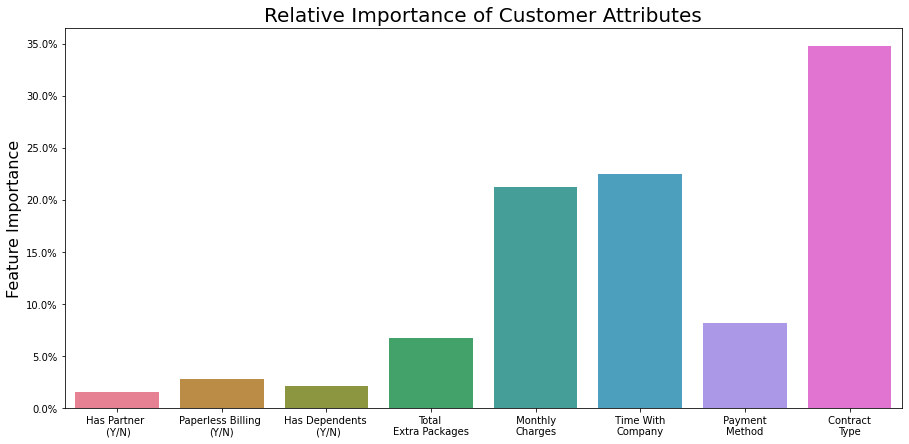

In [ ]:
# Creates a bar plot showing the importance of each feature within the final model 
final_features = ['Has Partner \n (Y/N)','Paperless Billing \n(Y/N)', 'Has Dependents \n (Y/N)', 'Total \nExtra Packages',
       ' Monthly \nCharges', ' Time With \nCompany',' Payment \nMethod',' Contract \nType']
importance = combined_feature_importance
fig, axs = plt.subplots(nrows = 1, ncols=1, figsize = (15,7))
sns.barplot(x = final_features, y = importance,palette=sns.color_palette("husl",8))
# axs.set_xlabel("Features" ,fontsize= 16)
axs.set_ylabel("Feature Importance",fontsize = 16)
axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
axs.set_title("Relative Importance of Customer Attributes",size = 20) 

# Additional model information/Metrics

## Initial Random Forest

### Confusion Matrices and classification reports
                                   Predicted
                          Negative          Positive
               Negative   True Negative     False Positive
      Actual
               Positive   False Negative    True Positive

* Accuracy: Proportion of correctly classed instances - TN + TP / total instances
* Precision: Proportion of correctly classed positive instances across all predicted positives - TP / TP + FP 
* Recall: Proportion of correctly classed positive instances in comparison to all true positives - TP / TP + FN <- good to use as appropriate when high cost associated with false negative
* F1: weighted average of Precision and Recall - 2 * (Precision * Recall) / (Precision + Recall) 



In [ ]:
# Fit baseline Random forest model
rand_for = RandomForestClassifier(max_depth=5,min_samples_split=7,n_estimators=300,class_weight={0:1, 1:1})
rand_for.fit(train_x, train_y)
rand_for_predictions = rand_for.predict(test_x)
print(classification_report(test_y, rand_for_predictions))
print(confusion_matrix(test_y, rand_for_predictions)) # Baseline confusion matrix

              precision    recall  f1-score   support

           0       0.80      0.94      0.87      1098
           1       0.69      0.37      0.48       396

    accuracy                           0.79      1494
   macro avg       0.75      0.65      0.67      1494
weighted avg       0.77      0.79      0.76      1494

[[1031   67]
 [ 250  146]]


In [ ]:
print(classification_report(test_y, rand_for_predictions))
print(confusion_matrix(test_y, rand_for_predictions)) # Setting class weights to {0:1, 1:3}

              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1098
           1       0.46      0.86      0.60       396

    accuracy                           0.70      1494
   macro avg       0.69      0.75      0.68      1494
weighted avg       0.80      0.70      0.71      1494

[[702 396]
 [ 57 339]]


In [ ]:
print(classification_report(test_y, rand_for_predictions))
print(confusion_matrix(test_y, rand_for_predictions)) # Setting class weights to {0:1, 1:5}

              precision    recall  f1-score   support

           0       0.94      0.54      0.68      1098
           1       0.41      0.91      0.57       396

    accuracy                           0.63      1494
   macro avg       0.68      0.72      0.63      1494
weighted avg       0.80      0.63      0.65      1494

[[588 510]
 [ 36 360]]


In [ ]:
print(classification_report(test_y, rand_for_predictions))
print(confusion_matrix(test_y, rand_for_predictions)) # Setting class weights to {0:1, 1:10}

              precision    recall  f1-score   support

           0       0.96      0.45      0.62      1098
           1       0.38      0.94      0.55       396

    accuracy                           0.58      1494
   macro avg       0.67      0.70      0.58      1494
weighted avg       0.81      0.58      0.60      1494

[[498 600]
 [ 22 374]]


### ROC score and Curve 

In [ ]:
y_probas_for= cross_val_predict(rand_for, train_x, train_y, cv = 3, method="predict_proba") # Done for class weights = {0:1, 1:3}
y_scores_for = y_probas_for[:, 1]
fpr_for,tpr_for,thresholds_for = roc_curve(train_y,y_scores_for)
roc_auc_score(train_y,y_scores_for)

0.8334375536568831

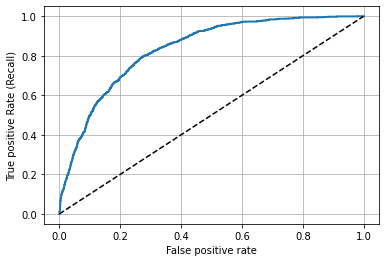

In [ ]:
plt.plot(fpr_for,tpr_for,label = "Random Forest",linewidth = 2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False positive rate")
plt.ylabel("True positive Rate (Recall)")
plt.grid() # Can see it performs okay. Could be better. 

## Final model 

### Confusion Matrices and Classification Reports

In [ ]:
rand_for_smote = RandomForestClassifier(max_depth=10,min_samples_split=5,n_estimators=300)
rand_for_smote.fit(x_train_res,y_train_res)
rand_for_predictions_smote = rand_for_smote.predict(x_test_res)
print(classification_report(y_test_res, rand_for_predictions_smote))
print(confusion_matrix(y_test_res, rand_for_predictions_smote))

              precision    recall  f1-score   support

           0       0.83      0.78      0.81      1103
           1       0.72      0.78      0.75       788

    accuracy                           0.78      1891
   macro avg       0.78      0.78      0.78      1891
weighted avg       0.79      0.78      0.78      1891

[[865 238]
 [174 614]]


In [ ]:
rand_for_smote = RandomForestClassifier(max_depth=10,min_samples_split=5,n_estimators=100,class_weight={0:1, 1:2})
rand_for_smote.fit(x_train_res,y_train_res)
rand_for_predictions_smote = rand_for_smote.predict(x_test_res)
print(classification_report(y_test_res, rand_for_predictions_smote))
print(confusion_matrix(y_test_res, rand_for_predictions_smote))

              precision    recall  f1-score   support

           0       0.89      0.70      0.79      1103
           1       0.68      0.88      0.77       788

    accuracy                           0.78      1891
   macro avg       0.78      0.79      0.78      1891
weighted avg       0.80      0.78      0.78      1891

[[775 328]
 [ 95 693]]


### ROC score and Curve

In [ ]:
rand_for_smote = RandomForestClassifier(max_depth=10,min_samples_split=5,n_estimators=100,class_weight={0:1, 1:2})
rand_for_smote.fit(x_train_res,y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_probas_for= cross_val_predict(rand_for_smote, x_train_res,y_train_res, cv = 3, method="predict_proba") # Done for class weights = {0:1, 1:2}
y_scores_for = y_probas_for[:, 1]
fpr_for,tpr_for,thresholds_for = roc_curve(y_train_res,y_scores_for)
roc_auc_score(y_train_res,y_scores_for)

0.8702516429017105

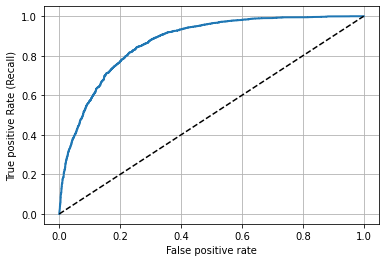

In [ ]:
plt.plot(fpr_for,tpr_for,label = "Random Forest",linewidth = 2)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False positive rate")
plt.ylabel("True positive Rate (Recall)")
plt.grid() # Can see this is an overall improvement on the best model which did not oversample.  (0.87, was 0.83 previously) 